# Studying NOAA's Storm Event database with Data Science

This python code is written to read NOAA's storm event database It creates a dataframe from the list of .csv files and allows the user to investigate how many times a particular type of event happened in the past (Number of events per year) starting from 1950 to 2017, and provide regression analysis to project occurrence of events in the future

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Reading a list of names for the text files containing storm event data
txtfile = open("flist.txt")
flist = txtfile.read().split('\n')
flist=flist[:-1]
flist_short=list(reversed(flist))
flist_short=flist_short[:22]
flist_short

['StormEvents_details-ftp_v1.0_d2017_c20171018.csv',
 'StormEvents_details-ftp_v1.0_d2016_c20171018.csv',
 'StormEvents_details-ftp_v1.0_d2015_c20170918.csv',
 'StormEvents_details-ftp_v1.0_d2014_c20170718.csv',
 'StormEvents_details-ftp_v1.0_d2013_c20170519.csv',
 'StormEvents_details-ftp_v1.0_d2012_c20170519.csv',
 'StormEvents_details-ftp_v1.0_d2011_c20170519.csv',
 'StormEvents_details-ftp_v1.0_d2010_c20170726.csv',
 'StormEvents_details-ftp_v1.0_d2009_c20170816.csv',
 'StormEvents_details-ftp_v1.0_d2008_c20170718.csv',
 'StormEvents_details-ftp_v1.0_d2007_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2006_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2005_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2004_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2003_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2002_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2001_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2000_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d1999_c20170717

Setting up a function for large numerical numbers:

In [3]:
def value_to_float(val):
    if type(val) == int or type(val) == float:
        return val
    if 'B' in val:
        return float(val.replace('B', '')) * 10**9
    if 'M' in val:
        if len(val) > 1:
            return float(val.replace('M', '')) * 10**6
        return 1000000.0
    if 'K' in val:
        if len(val) > 1:
            return float(val.replace('K', '')) * 10**3
        return 1000.0
    return 0.0


The first thing we can investigate is the valuable but tragic information from the database about the amound of damages on properties and crops as well as direct and indirect deaths and injuries caused by natural hazards in the U.S.

In [4]:
#For loop to generate a dataframe with data from all csv files
f1 = ['EVENT_TYPE','DAMAGE_PROPERTY','DAMAGE_CROPS','INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT']
i=0
for file in flist:
	df=pd.read_csv(file, usecols=f1)
	df.DAMAGE_PROPERTY = df.DAMAGE_PROPERTY.apply(value_to_float)
	df.DAMAGE_CROPS = df.DAMAGE_CROPS.apply(value_to_float)
	gp=df.groupby('EVENT_TYPE')
	D=gp.DAMAGE_PROPERTY.sum().fillna(0).reset_index()
	D['DAMAGE_CROPS']=gp.DAMAGE_CROPS.sum().fillna(0).reset_index().DAMAGE_CROPS
	C=gp.DEATHS_DIRECT.sum().fillna(0).reset_index()
	C['INJURIES_DIRECT']=gp.INJURIES_DIRECT.sum().fillna(0).reset_index().INJURIES_DIRECT
	if i==0:
		fullD=D
		fullC=C
	else:
		fullD=pd.merge(fullD,D,on='EVENT_TYPE',how='outer')
		fullC=pd.merge(fullC,C,on='EVENT_TYPE',how='outer')
	i+=1

#Organizing the data in the dataframe by calculating the total damages and casualties
nlist=list(range(1,fullD.shape[1]))
evenlist = [x for x in nlist if x % 2 == 0]
oddlist = [x for x in nlist if x % 2 != 0]

fullD['TOTAL_DP']=fullD.iloc[0:len(fullD),oddlist].sum(axis=1)
fullD['TOTAL_DC']=fullD.iloc[0:len(fullD),evenlist].sum(axis=1)
fullC['TOTAL_D']=fullC.iloc[0:len(fullC),oddlist].sum(axis=1)
fullC['TOTAL_I']=fullC.iloc[0:len(fullC),evenlist].sum(axis=1)
fullD['TOTAL_DAMAGE']=fullD['TOTAL_DP']+fullD['TOTAL_DC']
fullC['TOTAL_CASUALTIES']=fullC['TOTAL_D']+fullC['TOTAL_I']

Dplot=fullD.sort_values('TOTAL_DAMAGE').set_index('EVENT_TYPE').reset_index()
Dplot=Dplot[-10:]
Cplot=fullC.sort_values('TOTAL_CASUALTIES').set_index('EVENT_TYPE').reset_index()
Cplot=Cplot[-10:]

We can then plot the data with bar charts for easy viewing:

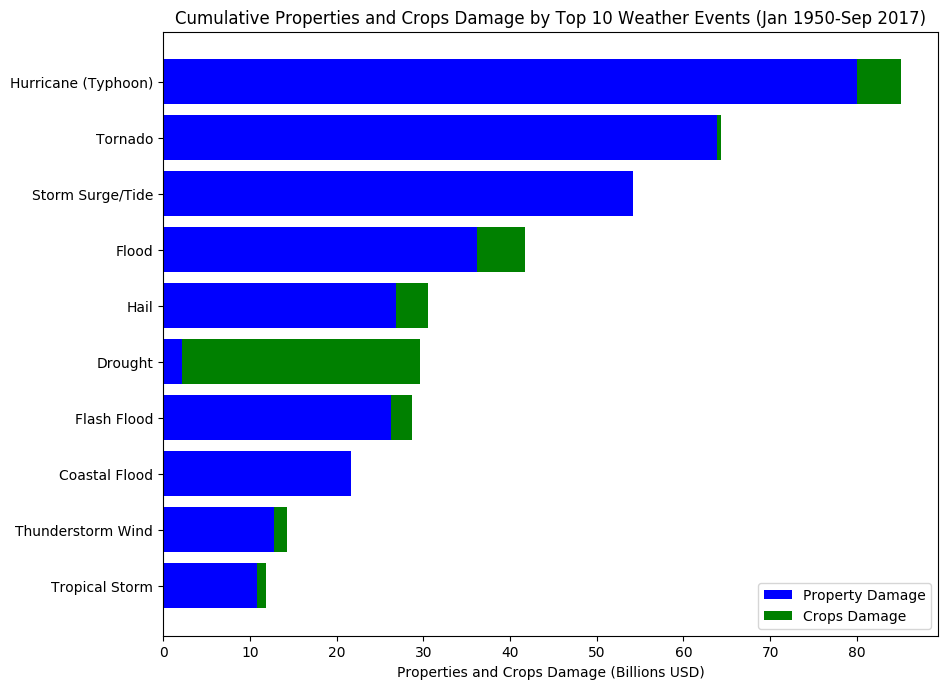

In [5]:
w=0.8
tlabel=Dplot.EVENT_TYPE
fig = plt.figure(figsize=(10,8), dpi=100)
p1 = plt.barh(Dplot.index, Dplot.TOTAL_DP.div(10**9), w, color='b', tick_label=tlabel)
p2 = plt.barh(Dplot.index, Dplot.TOTAL_DC.div(10**9), w, color='g', tick_label=tlabel, left=Dplot.TOTAL_DP.div(10**9))
plt.title('Cumulative Properties and Crops Damage by Top 10 Weather Events (Jan 1950-Sep 2017)')
plt.xlabel('Properties and Crops Damage (Billions USD)')
plt.legend(['Property Damage', 'Crops Damage'], loc='lower right')
plt.show()

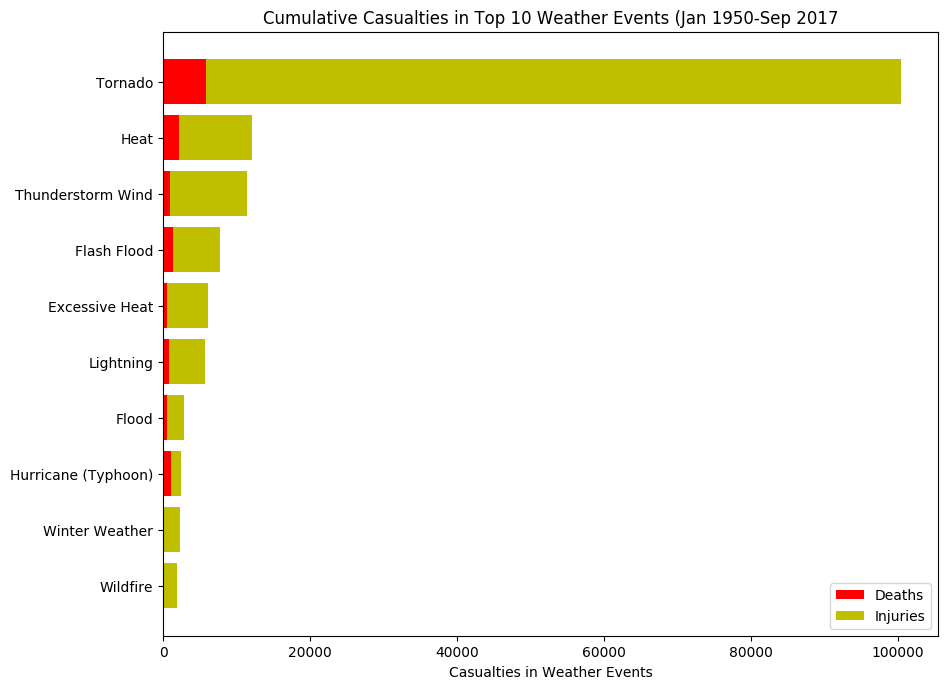

In [6]:
w=0.8
tlabel=Cplot.EVENT_TYPE
fig = plt.figure(figsize=(10,8), dpi=100)
p1 = plt.barh(Cplot.index, Cplot.TOTAL_D, w, color='r', tick_label=tlabel)
p2 = plt.barh(Cplot.index, Cplot.TOTAL_I, w, color='y', tick_label=tlabel, left=Cplot.TOTAL_D)
plt.title('Cumulative Casualties in Top 10 Weather Events (Jan 1950-Sep 2017')
plt.xlabel('Casualties in Weather Events')
plt.legend(['Deaths', 'Injuries'], loc='lower right')
plt.show()

How interesting! We can see that the hazards that caused the most damages - Hurricanes, are not the same as hazards that caused deaths and injuries - Tornadoes.

With that in mind, let's explore more data about Tornadoes in the U.S:

In [7]:
#Enter the event type you would like to investigate
events = input("Please enter your event of interest: ")

Please enter your event of interest: Tornado


In [8]:
#The event entered will be stored in a dictionary
vlist = [events]
#Composing a dictionary with the names of the lower 48 States
slist = ['ALABAMA',
'ARIZONA',
'ARKANSAS',
'CALIFORNIA',
'COLORADO',
'CONNECTICUT',
'DELAWARE',
'FLORIDA',
'GEORGIA',
'IDAHO',
'ILLINOIS',
'INDIANA',
'IOWA',
'KANSAS',
'KENTUCKY',
'LOUISIANA',
'MAINE',
'MARYLAND',
'MASSACHUSETTS',
'MICHIGAN',
'MINNESOTA',
'MISSISSIPPI',
'MISSOURI',
'MONTANA',
'NEBRASKA',
'NEVADA',
'NEW HAMPSHIRE',
'NEW JERSEY',
'NEW MEXICO',
'NEW YORK',
'NORTH CAROLINA',
'NORTH DAKOTA',
'OHIO',
'OKLAHOMA',
'OREGON',
'PENNSYLVANIA',
'RHODE ISLAND',
'SOUTH CAROLINA',
'SOUTH DAKOTA',
'TENNESSEE',
'TEXAS',
'UTAH',
'VERMONT',
'VIRGINIA',
'WASHINGTON',
'WEST VIRGINIA',
'WISCONSIN',
'WYOMING']
#Only two columns are needed from the data for this investigation
f2 = ['STATE','EVENT_TYPE']

In [9]:
#For loop to generate a dataframe with data from csv files from 1996-2017
i=0
for file in flist_short:
	df=pd.read_csv(file, usecols=f2)
	df=df[df['EVENT_TYPE'].isin(vlist)]
	df=df[df['STATE'].isin(slist)]
	df=df.groupby(['STATE']).count()
	df.columns=[file[30:34]]
	for j in range(0,47):
		if slist[j] not in df.index:
			dftemp = pd.DataFrame([0], columns=[file[30:34]], index=[slist[j]])
			df=pd.concat([df, dftemp])
	df=df.sort_index()
	if i==0:
		full=df
	else:
		full=full.join(df,  how='outer')
	i+=1


In [10]:
#Dataframe containing the amount of events from 1950 to 2017
full.head()

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,...,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996
ALABAMA,48,76,35,67,28,67,217,46,91,112,...,86,65,45,44,63,52,23,57,30,37
ARIZONA,2,1,5,3,1,1,3,12,4,3,...,9,3,9,0,4,0,5,2,5,9
ARKANSAS,40,28,21,25,41,23,104,47,59,110,...,69,58,89,39,52,42,140,39,47,33
CALIFORNIA,3,5,10,9,5,12,9,9,2,7,...,30,10,0,3,7,9,3,25,17,22
COLORADO,13,39,57,50,27,34,21,71,46,40,...,34,84,30,25,46,60,41,38,47,98


We have extracted the infromation about tornadoes in the lower 48 States.
Now let's see how many tornadoes happen every year (by States):

In [11]:
#Calculating average amount of Tornados per year in each State
full.avg=full.sum(axis=1)/full.shape[1]
full.avg

ALABAMA            64.227273
ARIZONA             3.954545
ARKANSAS           52.863636
CALIFORNIA          9.636364
COLORADO           44.500000
CONNECTICUT         1.590909
DELAWARE            0.409091
FLORIDA            55.772727
GEORGIA            41.681818
IDAHO               3.954545
ILLINOIS           64.090909
INDIANA            31.045455
IOWA               57.136364
KANSAS             99.318182
KENTUCKY           29.681818
LOUISIANA          42.000000
MAINE               2.409091
MARYLAND            9.363636
MASSACHUSETTS       1.545455
MICHIGAN           15.772727
MINNESOTA          46.590909
MISSISSIPPI        58.681818
MISSOURI           56.727273
MONTANA             7.454545
NEBRASKA           54.863636
NEVADA              1.727273
NEW HAMPSHIRE       1.136364
NEW JERSEY          1.500000
NEW MEXICO          8.454545
NEW YORK            9.045455
NORTH CAROLINA     32.727273
NORTH DAKOTA       35.454545
OHIO               21.181818
OKLAHOMA           75.681818
OREGON        

We can visualize the results with the power basemap package by overlaying the results on a map of the continental U.S:

In [12]:
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib import cm

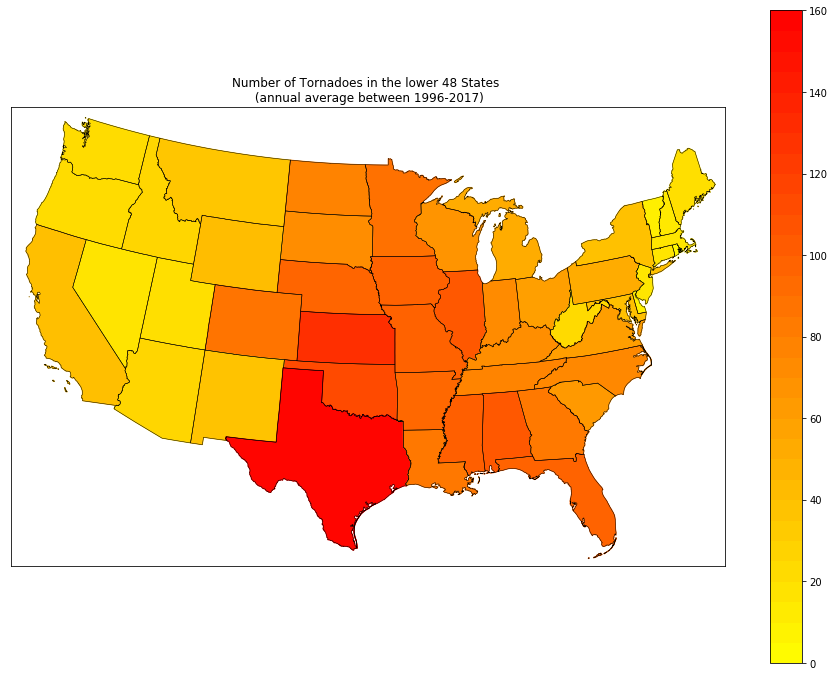

In [13]:
#Plot with basemap
full.index=full.index.str.title()
full_map=dict(zip(full.index, full.avg))

min, max = (0, 160)
step = 5
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
C_bar = plt.contourf(Z, levels, cmap = plt.cm.autumn_r)
plt.clf()

fig = plt.figure(figsize=(16,12))
ax = plt.gca()
colors={}
statenames=[]
cmap = plt.cm.autumn
min = 0; max = 150

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)

exclude=['District of Columbia','Puerto Rico','Alaska','Hawaii','American Samoa','Guam']
for shapedict in m.states_info:
    statename = shapedict['NAME']
    if statename not in exclude:
        a = full_map[statename]
        colors[statename] = cmap(1.-np.sqrt((a-min)/(max-min)))[:3]
    statenames.append(statename)

for nshape,seg in enumerate(m.states):
    if statenames[nshape] not in exclude:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

plt.title('Number of Tornadoes in the lower 48 States \n (annual average between 1996-2017)')
plt.colorbar(C_bar)
plt.show()

So Texas is hit most frequently with Tornadoes! According to this quick analysis, the residents there will be wise to invest in protective measures against tornadoes at their homes.

Discussion: Coincidently Texas is also the largerst state! Texas may be having so many Tornadoes simplity by being large and thus have more events every year. To understand it this is the case, the next step can be to refine the resolution of the results and plot the data on a county map (instead of a state map). This will give a better idea on if there was bias in the results we obtained so far. Other solution can also be grouping the events with their locations (longitude and latitude) to see how frequent tornadoes are in a given size of land.

We can also explore and see how many tornadoes happened every year since the beginning of data collection:

In [14]:
#For loop to generate a dataframe with data from all csv files
i=0
for file in flist:
	df=pd.read_csv(file, usecols=f2)
	df=df[df['EVENT_TYPE'].isin(vlist)]
	df=df[df['STATE'].isin(slist)]
	df=df.groupby(['STATE']).count()
	df.columns=[file[30:34]]
	for j in range(0,47):
		if slist[j] not in df.index:
			dftemp = pd.DataFrame([0], columns=[file[30:34]], index=[slist[j]])
			df=pd.concat([df, dftemp])
	df=df.sort_index()
	if i==0:
		full=df
	else:
		full=full.join(df,  how='outer')
	i+=1


In [15]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

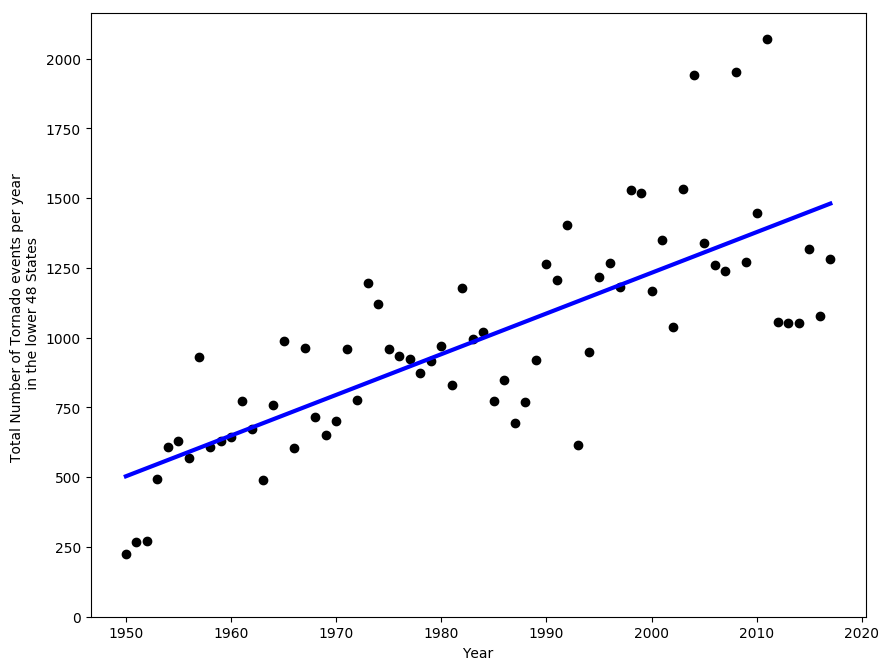

In [16]:
#Plot the data and fit a linear regression
regr = linear_model.LinearRegression()
x=list(range(1950,2017+1))
y=full.sum().astype(int)
x=np.asarray(x)
y=np.asarray(y)
x=x.reshape(-1,1)
y=y.reshape(-1,1)
regr.fit(x, y)
y_pred = regr.predict(x)
var=np.mean((y-y_pred)**2)
fig = plt.figure(figsize=(10,8), dpi=100)
plt.scatter(x, y,  color='black')
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Total Number of '+events+' events per year \n in the lower 48 States')
plt.ylim(ymin=0)
plt.show()

We can see there were a linear trend.

Discussion: Was it an effect of better instrumentation in recording Tornadoes? Or was it climate change? To understand this further a next step can be bringing in additional data such as global temperature or understand the method of recording to see if there is any coorelation.

Let's compute the R squared value:

In [17]:
#Coefficient of determination of the fitted line
print('Coefficient of determination : %.2f' % r2_score(y, y_pred))

Coefficient of determination : 0.59


It is not very high but acceptable for data related to environmental events. We can then use this fit to estimate how many tornadoes we may get in the coming years:

In [18]:
#Assuming the linear regression as fitted,
#the amound of Tornados in the lower 48 States by 2050 will be:
regr.predict(2050)[0][0]

1961.8393327480262

In [19]:
#With the variance of the prediction being:
var=np.sqrt(sum((y-y_pred)**2)/len(y))
var[0]

236.75870764137008

We can project that by 2050 we will have about 2000(!) Tornados every year with + or - 240 events in the lower 48 States of U.S. That is a lot of Tornadoes!

We must prepare for more Tornadoes then. But can we put it off this year and wait for the next 'Tornado season'? When do Tornadoes happen most frequently in the calendar year? We can obtain this information from the database as well:

In [20]:
#Only two columns are needed from the data for this investigation
f3 = ['EVENT_TYPE','MONTH_NAME']
#For loop to generate a dataframe with data from all csv files
i=0
for file in flist[:-1]:
	df=pd.read_csv(file, usecols=f3)
	df=df[df['EVENT_TYPE'].isin(vlist)]
	df=df.groupby(['MONTH_NAME']).count()
	df.columns=[file[30:34]]
#	for j in range(0,11):
#		if slist[j] not in df.index:
#		dftemp = pd.DataFrame([0], columns=[file[30:34]], index=[slist[j]])
#			df=pd.concat([df, dftemp])
#	df=df.sort_index()
	if i==0:
		full_month=df
	else:
		full_month=full_month.join(df,  how='outer')
	i+=1


In [21]:
full_month.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
MONTH_NAME,,,,,,,,,,,,,,,,,,,,,
April,17,27,42.0,53,132,107,125,244,85,31,...,188,212,260,176,1020,231,94,168,191,154
August,14,27,20.0,24,49,33,44,20,46,38,...,86,105,67,62,63,40,55,79,51,93
December,6,10,5.0,31,26,3,13,43,1,2,...,19,48,51,44,20,61,22,20,104,21
February,27,12,31.0,17,19,4,53,5,31,25,...,70,191,46,1,77,79,44,52,3,119
January,8,3,13.0,15,3,3,4,19,11,17,...,22,103,6,34,18,88,95,4,31,19


In [22]:
full_month=full_month.reset_index()
full_month.MONTH_NAME=pd.Categorical(full_month.MONTH_NAME, ['January','February','March','April','May','June','July','August','September','October','November','December'])
full_month=full_month.sort_values('MONTH_NAME').reset_index()
full_month=full_month.drop('index', axis=1)

In [23]:
#Calculating average amount of Tornados per year in each State
full_month.avg=full_month.sum(axis=1)/full_month.shape[1]
full_month.avg

0      23.794118
1      30.000000
2      66.970588
3     146.926471
4     215.705882
5     177.647059
6      95.088235
7      64.382353
8      49.279412
9      37.882353
10     42.441176
11     23.823529
dtype: float64

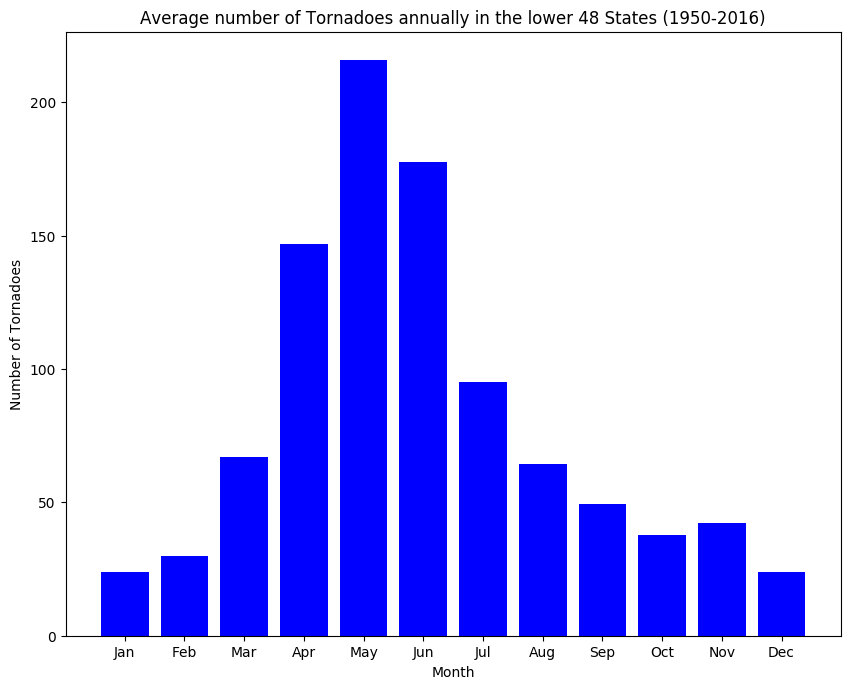

In [24]:
w=0.8
tlabel=full_month.index
fig = plt.figure(figsize=(10,8), dpi=100)
p1 = plt.bar(full_month.index, full_month.avg, w, color='b', tick_label=tlabel)
plt.title('Average number of '+events+'es annually in the lower 48 States (1950-2016)')
plt.xlabel('Month')
plt.xticks(full_month.index,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Number of '+events+'es')
plt.show()

So it seems the Tornado season starts in April and peaks in May, we still have time to prepare for it then! (as it is only November now)